In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchtext.vocab as vocab
from torch.utils.data import DataLoader, Dataset

df = pd.read_csv('dataset.csv')
# bỏ cột app_id và app_name
df = df.drop(['app_id', 'app_name'], axis=1)
# bỏ các dòng mà có review_text là NaN
df = df.dropna(subset=['review_text'])

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
torch.manual_seed(SEED)

In [36]:
np.random.seed(42)
sample_id = np.random.choice(df.index, 300000, replace=False) # lấy ngẫu nhiên 300000 dòng, replace=False để không lấy trùng
data = df.copy()
data = data.loc[sample_id, ['review_text', 'review_score']] # lấy 300000 dòng của 2 cột review_text và review_score
data = data[data['review_text'].str.contains('Early Access Review') == False] 

In [37]:
from sklearn.model_selection import train_test_split

train_data, validate_data = train_test_split(data, test_size=0.2)
validate_data, test_data = train_test_split(validate_data, test_size=0.5)
train_data.shape, test_data.shape, validate_data.shape

((201878, 2), (25235, 2), (25235, 2))

In [38]:
from collections import Counter
from utils import *

tokens_count = Counter()
for line in data.review_text:
    tokens_count.update(tokenizer(preprocess_review(line)))
print(f'So luong cac token: {len(tokens_count)}')

So luong cac token: 180815


In [39]:
from collections import OrderedDict
from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(tokens_count.items(), 
                               key=lambda x: x[1], 
                               reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
vocab_review = vocab(ordered_dict) # 
# padding
vocab_review.insert_token('<pad>', 0)
# unknown
vocab_review.insert_token('<unk>', 1)
vocab_review.set_default_index(1)
print(f'Vocabulary size: {len(vocab_review)}')
print([vocab_review[token] for token in 
      ['my','whole','live','i','have','tried']])

Vocabulary size: 180817
[33, 295, 777, 8, 20, 480]


In [40]:
text_pipeline = lambda x: [vocab_review[token] for token in tokenizer(x)]
label_pipeline = lambda x: 1. if x == 1 else 0.  # we need float labels for BCEWithLogitsLoss

def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        if not isinstance(_text, str):
            continue
        processed_text = torch.tensor(text_pipeline(_text),
                                      dtype=torch.int64)
        if processed_text.size(0) > 0:
            label_list.append(label_pipeline(_label))
            text_list.append(processed_text)
            lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list, label_list, lengths

# check a small batch
tmp = DataLoader(list(zip(df.review_score, df.review_text)), batch_size=4, shuffle = False, collate_fn = collate_batch)
text_batch, label_batch, length_batch = next(iter(tmp))
print('text batch:', text_batch)
print('label batch:', label_batch)
print('length batch:', length_batch)
print('text batch shape:', text_batch.shape)

text batch: tensor([[   1,   33,  224,  ...,    0,    0,    0],
        [   1,   32,   26,  ...,  824,  129,    1],
        [   1,    7, 2149,  ...,    0,    0,    0],
        [   1,    1,   10,  ...,    0,    0,    0]])
label batch: tensor([1., 1., 1., 1.])
length batch: tensor([  4, 510,   6,  55])
text batch shape: torch.Size([4, 510])


In [41]:
batch_size = 32
train_dl = DataLoader(list(zip(train_data.review_score, train_data.review_text)), batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch) # 
valid_dl = DataLoader(list(zip(validate_data.review_score, validate_data.review_text)), batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(list(zip(test_data.review_score, test_data.review_text)), batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)

In [42]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        # sentence embedding
        self.embedding = nn.Embedding(num_embeddings = vocab_size, 
                                      embedding_dim = embed_dim, 
                                      padding_idx = 0)
        # RNN layer
        # input dimensions are: (batch, seq, feature) 
        self.rnn = nn.RNN(input_size = embed_dim, 
                           hidden_size = rnn_hidden_size, 
                           batch_first = True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, text, lengths):
        out = self.embedding(text)
        # pad sententences with zero, lengths are the before padded
        out = nn.utils.rnn.pack_padded_sequence(out, 
                                                lengths.cpu().numpy(), 
                                                enforce_sorted = False, 
                                                batch_first = True)
        # output, hidden state
        # hidden state shape: D*num_layers, batch size, out_dim
        out, hidden = self.rnn(out)
        out = hidden[-1,:,:] # -1;:,: means last layer, all batches, all hidden units
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [43]:
torch.manual_seed(SEED)
vocab_size = len(vocab_review)
embed_dim = 10
rnn_hidden_size = 8
fc_hidden_size = 4
model_rnn = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
model_rnn

RNN(
  (embedding): Embedding(180817, 10, padding_idx=0)
  (rnn): RNN(10, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [44]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

In [45]:
def acc(pred, y):
    pred = torch.round(torch.sigmoid(pred))
    correct = (pred == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [46]:
def train(model ,dataloader):
    model.train()
    total_acc, total_loss = 0., 0.
    for batch_idx, (text_batch, label_batch, lengths) in enumerate(dataloader):
        text_batch = text_batch.to(device)
        label_batch = label_batch.to(device)
        pred = model(text_batch, lengths)[:, 0] # only get the last output
        loss = loss_fn(pred, label_batch.float()) # loss function
        optimizer.zero_grad() # clear gradients
        loss.backward() # backpropagation
        optimizer.step() # update weights
        total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(model, dataloader):
    model.eval() # 
    total_acc, total_loss = 0., 0.
    with torch.no_grad(): # No need to backpropagation
        for text_batch, label_batch, lengths in dataloader:
            text_batch = text_batch.to(device)
            label_batch = label_batch.to(device)
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch.float())
            total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

In [50]:
import os 
# If model is already trained, load it
skip_training = True
if os.path.isfile('model/rnn.pth'):
    model_rnn.load_state_dict(torch.load('model/rnn.pth'))
    model_rnn.to(device)
    print('Model loaded')
else:
    print('Start training')
    skip_training = False

Model loaded


In [51]:
if not skip_training:
    num_epochs = 5
    torch.manual_seed(SEED)
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model_rnn.to(device)
        acc_train, loss_train = train(model_rnn, train_dl)
        acc_valid, loss_valid = evaluate(model_rnn, valid_dl)
        print(f'Epoch {epoch} accuracy: {acc_train:.4f}'
            f' val_accuracy: {acc_valid:.4f}')
        loss_hist_train[epoch] = loss_train
        accuracy_hist_train[epoch] = acc_train
        loss_hist_valid[epoch] = loss_valid
        accuracy_hist_valid[epoch] = acc_valid
    torch.save(model_rnn.state_dict(), 'model/rnn.pth')
else:
    print('Skip training')

Skip training


In [53]:
if not skip_training:
    my_dpi = 100
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(540/my_dpi, 720/my_dpi), dpi=my_dpi)
    ax[0].plot(loss_hist_train, lw=2)
    ax[0].plot(loss_hist_valid, lw=2)
    ax[0].legend(['Train loss', 'Validation loss'], fontsize=12)
    ax[0].set_xlabel('Epochs', size=12)
    ax[1].plot(accuracy_hist_train, lw=2)
    ax[1].plot(accuracy_hist_valid, lw=2)
    ax[1].legend(['Train acc.', 'Validation acc.'], fontsize=12)
    ax[1].set_xlabel('Epochs', size=12);
    plt.tight_layout()
    plt.savefig(f'model_train_history_rnn.png', dpi = my_dpi);
    plt.show()
else:
    print('There is no training history')

There is no training history


In [54]:
# Test the model
acc_test, loss_test = evaluate(model_rnn, test_dl)
print(f'test accuracy: {acc_test:.4f}')

test accuracy: 0.8621


In [55]:
model_rnn.eval()

with torch.no_grad():
    for x_batch, y_batch, lengths in test_dl:
        break
        
x_batch = x_batch.to(device)
pred = model_rnn(x_batch, lengths)[:, 0]

for i in range(5):
    print('\nReview text:', ' '.join([vocab_review.get_itos()[j] for j in x_batch[i] if j != 0]))
    print('True label =', y_batch[i].item(),', model prediction', pred[i].item())


Review text: <unk> great
True label = 1.0 , model prediction 0.9683519005775452

Review text: <unk> version is really fun to play <unk>
True label = 1.0 , model prediction 0.9320012927055359

Review text: <unk> is very probably one of the best games ever to grace this world <unk> <unk> the <unk> years of experience I <unk> had with gaming <unk> I have played various titles such as <unk> <unk> <unk> <unk> <unk> <unk> and <unk> for the <unk> <unk> <unk> and I must admit this is an almost better experience than those two <unk> <unk> graphics are amazing for a game originally meant to be played on a <unk> calculator and the sound effects remind me of the good old days of the <unk> <unk> <unk> <unk> may say that the lip syncing is awful <unk> but I disagree <unk> <unk> is clearly intentional <unk> <unk> developers were trying to pass the message that the words that come out of your mouth are <unk> always what your heart wanted you to say <unk> <unk> example of a philosophical message passe

In [56]:
### Build a LSTM model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden_size, fc_hidden_size):
        super().__init__()
        # sentence embedding
        self.embedding = nn.Embedding(num_embeddings = vocab_size, 
                                      embedding_dim = embed_dim, 
                                      padding_idx = 0)
        self.lstm = nn.LSTM(input_size = embed_dim, 
                           hidden_size = lstm_hidden_size, 
                           batch_first = True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, text, lengths):
        out = self.embedding(text)
        # pad sententences with zero, lengths are the before padded
        out = nn.utils.rnn.pack_padded_sequence(out, 
                                                lengths.cpu().numpy(), 
                                                enforce_sorted = False, 
                                                batch_first = True)
        # output, hidden state
        # hidden state shape: D*num_layers, batch size, out_dim
        out, (hidden, cell) = self.lstm(out) 
        out = hidden[-1,:,:]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [57]:
torch.manual_seed(SEED)
vocab_size = len(vocab_review)
embed_dim = 10
lstm_hidden_size = 8
fc_hidden_size = 4
model_lstm = LSTM(vocab_size, embed_dim, lstm_hidden_size, fc_hidden_size)
model_lstm

LSTM(
  (embedding): Embedding(180817, 10, padding_idx=0)
  (lstm): LSTM(10, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [58]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr = 0.001)

In [60]:
import os 
# If model is already trained, load it
skip_training = True
if os.path.isfile('model/lstm.pth'):
    model_lstm.load_state_dict(torch.load('model/lstm.pth'))
    model_lstm.to(device)
    print('Model loaded')
else:
    print('Start training')
    skip_training = False

Start training


In [62]:
if not skip_training:
    num_epochs = 5
    torch.manual_seed(SEED)
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model_lstm.to(device)
        acc_train, loss_train = train(model_lstm, train_dl)
        acc_valid, loss_valid = evaluate(model_lstm, valid_dl)
        print(f'Epoch {epoch} accuracy: {acc_train:.4f}'
            f' val_accuracy: {acc_valid:.4f}')
        loss_hist_train[epoch] = loss_train
        accuracy_hist_train[epoch] = acc_train
        loss_hist_valid[epoch] = loss_valid
        accuracy_hist_valid[epoch] = acc_valid
    torch.save(model_lstm.state_dict(), 'model/lstm.pth')
else:
    print('Skip training')

Epoch 0 accuracy: 0.8255 val_accuracy: 0.8198
Epoch 1 accuracy: 0.8526 val_accuracy: 0.8615
Epoch 2 accuracy: 0.8803 val_accuracy: 0.8813
Epoch 3 accuracy: 0.8919 val_accuracy: 0.8863
Epoch 4 accuracy: 0.8989 val_accuracy: 0.8810


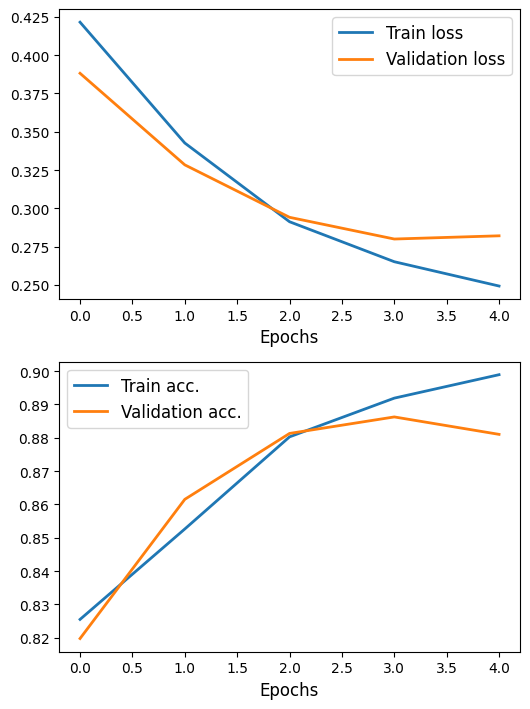

In [63]:
if not skip_training:
    my_dpi = 100
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(540/my_dpi, 720/my_dpi), dpi=my_dpi)
    ax[0].plot(loss_hist_train, lw=2)
    ax[0].plot(loss_hist_valid, lw=2)
    ax[0].legend(['Train loss', 'Validation loss'], fontsize=12)
    ax[0].set_xlabel('Epochs', size=12)
    ax[1].plot(accuracy_hist_train, lw=2)
    ax[1].plot(accuracy_hist_valid, lw=2)
    ax[1].legend(['Train acc.', 'Validation acc.'], fontsize=12)
    ax[1].set_xlabel('Epochs', size=12);
    plt.tight_layout()
    plt.savefig(f'model_train_history_lstm.png', dpi = my_dpi);
    plt.show()
else:
    print('There is no training history')

In [ ]:
model_lstm.eval()

with torch.no_grad():
    for x_batch, y_batch, lengths in test_dl:
        break
        
x_batch = x_batch.to(device)
pred = model_lstm(x_batch, lengths)[:, 0]

for i in range(5):
    print('\nReview text:', ' '.join([vocab_review.get_itos()[j] for j in x_batch[i] if j != 0]))
    print('True label =', y_batch[i].item(),', model prediction', pred[i].item())